<div style="line-height:1.2;">

<h1 style="color:#BF66F2; margin-bottom: 0.5em;">Semi-Supervised Generative Adversarial Networks in PyTorch</h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1.5em;">Implementation of a SGAN model. From Kaggle all_dogs challenge.</h4>

<div style="line-height:1.4; margin-bottom: 1em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> 
    glob + ElementTree + upload via gdrive + zipfile + @dataclass decorator + zero_grad()
</div>

<div style="line-height:1.4; margin-top: 1em;">
    <h3 style="color: red; display: inline; margin-right: 0.5em;">Notes:</h3> The dataset was not uploaded due to its magnitude.
</div>

</div>

<div style="line-height:1.2;">

<h1 style="color:#BF66F2; margin-bottom: 0.3em;">  Semi-Supervised Generative Adversarial Networks in PyTorch </h1>

<h4 style="margin-top: 0.3em; margin-bottom: 1em;"> Implementation of a DCGANs model,  on the KMNIST dataset. </h4>

<div style="line-height:1.4; margin-bottom: 0.5em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3> 
glob + ElementTree + upload via gdrive + zipfile + @dataclass decorator + zero_grad()
</div>

</div>

<div style="line-height:0.5">
<div style="line-height:1">
<h1 style="color:#BF66F2 ">  Semi-Supervised Generative Adversarial Networks in PyTorch </h1>
<div style="line-height:0.2">
<span style="display: inline-block;">
    <h3 style="color: lightblue; display: inline;">Keywords:</h3>
    glob + ElementTree + upload via gdrive + zipfile + @dataclass decorator + zero_grad()
</span>
</div>
<br>
<div style="margin-top: -12px;\">
<div style="line-height:1.2\">
<span style="display: inline-block;\">
    <h3 style="color: red; display: inline;\">Notes:</h3> The dataset was not uploaded due to its magnitude.
</span>
</div>
</div>

<h3 style="color:#BF66F2 ">  Recap: SGAN </h3>
<div style="margin-top: -18px;">
<div style="line-height:1.1">
A Semi-Supervised Generative Adversarial Network is a variant of GAN designed to leverage both labeled and unlabeled data during training. <br>
It also to perform classification on the real samples, with the the discriminator. <br>
Useful when labeled data is scarce.
</div>
</div>

In [4]:
import os
import glob
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET

from google.colab import files, drive

In [5]:
""" Access and upload data from drive.
N.B.
Avoid to upload files with zip. Too slow!
using => "uploaded_1 = files.upload()"
"""

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
zip_images = "/content/drive/My Drive/Colab_datasets/all-dogs.zip"

In [10]:
zip_annots = "/content/drive/My Drive/Colab_datasets/Annotation.zip"

In [11]:
""" Extract the datasets into /content dir"""
with zipfile.ZipFile(zip_images, 'r') as zip_ref_1:
    zip_ref_1.extractall('/content/')
with zipfile.ZipFile(zip_annots, 'r') as zip_ref_2:
    zip_ref_2.extractall('/content/')

In [12]:
IMAGE_PATH = '/content/all-dogs/'
ANNOT_PATH = '/content/Annotation/'

annotations = os.listdir(ANNOT_PATH)
images = os.listdir(IMAGE_PATH)

In [14]:
%%script echo Skip when using Colab
IMAGE_PATH = 'dataset/all-dogs/'
ANNOT_PATH = 'dataset/Annotation/'

annotations = os.listdir(ANNOT_PATH)
images = os.listdir(IMAGE_PATH)

Skip when using Colab


In [44]:
@dataclass
class TrainConfig:
    num_workers: int = 4
    epochs: int = 50
    batch_size: int = 64
    generate_size: int = 10_000
    save_epoch: int = 5

    mean: float = 0.5
    std: float = 0.5

    num_channels: int = 3
    image_size: int = 64
    feature_size: int = 64
    noise_size: int = 100
    embedding_dim: int = 256
    attention: bool = True

    device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
train_config = TrainConfig()

In [46]:
print(f"Number of breeds: {len(annotations)}")
print(f"Number of images: {len(images)}")

Number of breeds: 120
Number of images: 20579


In [47]:
for breed in annotations:
    annotations += glob.glob(breed+'/*')
print(f"Number of available annotations: {len(annotations)}")

Number of available annotations: 120


In [48]:
breed_map = {}
for annotation in annotations:
    index, *breed = annotation.split("-")
    breed_map[index] = index + "-" + "-".join(breed)
print(f"Number of breeds in breed_map: {len(breed_map)}")

Number of breeds in breed_map: 120


In [49]:
breed_map

{'n02107142': 'n02107142-Doberman',
 'n02099429': 'n02099429-curly-coated_retriever',
 'n02087394': 'n02087394-Rhodesian_ridgeback',
 'n02097298': 'n02097298-Scotch_terrier',
 'n02088094': 'n02088094-Afghan_hound',
 'n02092002': 'n02092002-Scottish_deerhound',
 'n02099267': 'n02099267-flat-coated_retriever',
 'n02098286': 'n02098286-West_Highland_white_terrier',
 'n02090622': 'n02090622-borzoi',
 'n02095889': 'n02095889-Sealyham_terrier',
 'n02101556': 'n02101556-clumber',
 'n02089973': 'n02089973-English_foxhound',
 'n02107683': 'n02107683-Bernese_mountain_dog',
 'n02094114': 'n02094114-Norfolk_terrier',
 'n02106382': 'n02106382-Bouvier_des_Flandres',
 'n02110627': 'n02110627-affenpinscher',
 'n02106166': 'n02106166-Border_collie',
 'n02100877': 'n02100877-Irish_setter',
 'n02098413': 'n02098413-Lhasa',
 'n02086910': 'n02086910-papillon',
 'n02089867': 'n02089867-Walker_hound',
 'n02091032': 'n02091032-Italian_greyhound',
 'n02091831': 'n02091831-Saluki',
 'n02106030': 'n02106030-coll

In [50]:
def bounding_box(annot_path, image):
    """ Extract bounding box coordinates for a given image's objects from the image XML annotation.

    Parameters:
        - Path to the directory containing XML annotations [str]
        - Image filename [str]

    Returns:
        - List of tuples, where each tuple contains the bounding box coordinates: (x_min, y_min, x_max, y_max).
    """
    # Compose the annotation path with breed and image name, to form the full path to the XML annotation file
    bounding_path = annot_path + str(breed_map[image.split("_")[0]]) + "/" + str(image.split(".")[0])
    print("bounding_path")
    print(bounding_path)
    # Parse the XML file at the specified path
    tree = ET.parse(bounding_path)
    # Get the root element of the XML doc
    root = tree.getroot()
    # Find all annotated "object" elements in the XML
    objects = root.findall("object")
    bboxes = []
    for o in objects:
        # Find the "bndbox" element which contains the bounding box coordinates
        bound_box = o.find("bndbox")
        x_min = int(bound_box.find("xmin").text)
        y_min = int(bound_box.find("ymin").text)
        x_max = int(bound_box.find("xmax").text)
        y_max = int(bound_box.find("ymax").text)
        # Add the coordinates as a tuple to a list
        bboxes.append((x_min, y_min, x_max, y_max))
    return bboxes



In [51]:
def bounding_box_ratio(annot_path, image):
    """ Retrieve not only the bounding box dimensions (width and height)\\
    but also compute the height-to-width ratio for objects in an image from its XML annotation.

    Parameters:
        - Path to the directory containing XML annotations [str]
        - Image filename [str]

    Returns:
        - List of tuples, where each tuple contains three values representing
            the bounding box width, height, and ratio.
    """
    # Construct the path to the XML annotation file by joining the annotation path with breed and image name
    bounding_path = annot_path + str(breed_map[image.split("_")[0]]) + "/" + str(image.split(".")[0])
    print(bounding_path)
    tree = ET.parse(bounding_path)
    root = tree.getroot()
    objects = root.findall("object")
    bbox_ratios = []
    for o in objects:
        bound_box = o.find("bndbox")
        x_min = int(bound_box.find("xmin").text)
        y_min = int(bound_box.find("ymin").text)
        x_max = int(bound_box.find("xmax").text)
        y_max = int(bound_box.find("ymax").text)
        # Get the width and height of the bounding box
        x_len = x_max - x_min
        y_len = y_max - y_min
        # Calculate the ratio of height to width for the bounding box
        ratio = y_len / x_len
        # Append the dimensions and ratio (as a tuple)
        bbox_ratios.append((x_len, y_len, ratio))
    return bbox_ratios

<h3 style="color:#BF66F2"> Recap: </h3>
<div style="margin-top: -27px;">
It is possible to measure the code block's time with the Jupyter magic command '%%time'.
</div>

In [52]:
%%time
#threshold for aspect ratio, at the same time idx for each bbx
images_th = []

for image in tqdm(images):
    bbox_ratios = bounding_box_ratio(ANNOT_PATH, image)
    for i,(x_len, y_len, ratio) in enumerate(bbox_ratios):
        if ((ratio > 0.2) & (ratio < 4.0)):
            images_th.append(image[:-4] + '_' + str(i) + '.jpg')

print(f"Original Length: {len(images)}")
print(f"After Thresholding Length: {len(images_th)}")

  0%|          | 0/20579 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/content/Annotation/n02095889-Sealyham_terrier/n02095889_662
/content/Annotation/n02111889-Samoyed/n02111889_7207
/content/Annotation/n02085936-Maltese_dog/n02085936_22167
/content/Annotation/n02113712-miniature_poodle/n02113712_3196
/content/Annotation/n02115641-dingo/n02115641_1674
/content/Annotation/n02108551-Tibetan_mastiff/n02108551_1724
/content/Annotation/n02094258-Norwich_terrier/n02094258_1408
/content/Annotation/n02101556-clumber/n02101556_438
/content/Annotation/n02090379-redbone/n02090379_4875
/content/Annotation/n02091467-Norwegian_elkhound/n02091467_3469
/content/Annotation/n02108422-bull_mastiff/n02108422_2052
/content/Annotation/n02100583-vizsla/n02100583_4228
/content/Annotation/n02085620-Chihuahua/n02085620_4266
/content/Annotation/n02112018-Pomeranian/n02112018_12137
/content/Annotation/n02105855-Shetland_sheepdog/n02105855_15882
/content/Annotation/n02092002-Scottish_deerhound/n02092002_1693
/content/Annotation/n02

In [53]:
""" Remove images that can lead to problems.
N.B.
from https://www.kaggle.com/korovai/dogs-images-intruders-extraction
"""

intruders = [
    #n02088238-basset
    'n02088238_10870_0.jpg',

    #n02088466-bloodhound
    'n02088466_6901_1.jpg',
    'n02088466_6963_0.jpg',
    'n02088466_9167_0.jpg',
    'n02088466_9167_1.jpg',
    'n02088466_9167_2.jpg',

    #n02089867-Walker_hound
    'n02089867_2221_0.jpg',
    'n02089867_2227_1.jpg',

    #n02089973-English_foxhound # No details
    'n02089973_1132_3.jpg',
    'n02089973_1352_3.jpg',
    'n02089973_1458_1.jpg',
    'n02089973_1799_2.jpg',
    'n02089973_2791_3.jpg',
    'n02089973_4055_0.jpg',
    'n02089973_4185_1.jpg',
    'n02089973_4185_2.jpg',

    #n02090379-redbone
    'n02090379_4673_1.jpg',
    'n02090379_4875_1.jpg',

    #n02090622-borzoi # Confusing
    'n02090622_7705_1.jpg',
    'n02090622_9358_1.jpg',
    'n02090622_9883_1.jpg',

    #n02090721-Irish_wolfhound # very small
    'n02090721_209_1.jpg',
    'n02090721_1222_1.jpg',
    'n02090721_1534_1.jpg',
    'n02090721_1835_1.jpg',
    'n02090721_3999_1.jpg',
    'n02090721_4089_1.jpg',
    'n02090721_4276_2.jpg',

    #n02091032-Italian_greyhound
    'n02091032_722_1.jpg',
    'n02091032_745_1.jpg',
    'n02091032_1773_0.jpg',
    'n02091032_9592_0.jpg',

    #n02091134-whippet
    'n02091134_2349_1.jpg',
    'n02091134_14246_2.jpg',

    #n02091244-Ibizan_hound
    'n02091244_583_1.jpg',
    'n02091244_2407_0.jpg',
    'n02091244_3438_1.jpg',
    'n02091244_5639_1.jpg',
    'n02091244_5639_2.jpg',

    #n02091467-Norwegian_elkhound
    'n02091467_473_0.jpg',
    'n02091467_4386_1.jpg',
    'n02091467_4427_1.jpg',
    'n02091467_4558_1.jpg',
    'n02091467_4560_1.jpg',

    #n02091635-otterhound
    'n02091635_1192_1.jpg',
    'n02091635_4422_0.jpg',

    #n02091831-Saluki
    'n02091831_1594_1.jpg',
    'n02091831_2880_0.jpg',
    'n02091831_7237_1.jpg',

    #n02092002-Scottish_deerhound
    'n02092002_1551_1.jpg',
    'n02092002_1937_1.jpg',
    'n02092002_4218_0.jpg',
    'n02092002_4596_0.jpg',
    'n02092002_5246_1.jpg',
    'n02092002_6518_0.jpg',

    #02093256-Staffordshire_bullterrier
    'n02093256_1826_1.jpg',
    'n02093256_4997_0.jpg',
    'n02093256_14914_0.jpg',

    #n02093428-American_Staffordshire_terrier
    'n02093428_5662_0.jpg',
    'n02093428_6949_1.jpg'
            ]

print(f"Number of intruders: {len(intruders)}")

Number of intruders: 60


In [54]:
class DogDataset(torch.utils.data.Dataset):
    """ Custom dataset class to manage dog images.\\
        Inherits from torch's Dataset class.

    Attributes:
        - ANNOT_PATH (str): Path to the folder containing annotations for the images
        - IMAGE_PATH (str): Path to the folder containing dog images
        - image_list (list): List of image file names to be processed
        - transform (callable, optional): Optional transform(s) to be applied on an image
        - images (list): List of processed images
        - labels (list): List of labels corresponding to each image in `images`

    Methods:
        __init__: Initializes the dataset and preprocesses the images
        _data_preprocessing: Processes an image using its bounding box information
        __len__: Returns the number of images in the dataset
        __getitem__: Fetches an image and its label by its index

    Details:
        - Extended unpacking at line => "*image_name, bbox_idx = image_path.split("_")"\\
        Split the "image_path" string into a list of substrings (with the underscore as a delimiter)
            - The asterisk is used to capture all elements of the list except the last one.

    Usage:
        >>> dataset = DogDataset(annot_path, image_path, image_list, label_map, transform=transforms.ToTensor())

    Notes:
        Need a PyTorch DataLoader obj for batch processing.
    """
    def __init__(self, annot_path, image_path, image_list, label_map, transform=None, intruders=[]):
        """ Initialize the dataset with necessary parameters. Then start preprocessing the data. """
        self.ANNOT_PATH = annot_path
        self.IMAGE_PATH = image_path
        self.image_list = image_list
        self.transform = transform
        self.labels, self.images = [], []

        ############# Process each image in the list
        for image_path in self.image_list:
            # Skip if the image is in the intruders list
            if image_path in intruders:
                continue

            ## Extract the image name and bounding box index from the image path
            *image_name, bbox_idx = image_path.split("_")
            image_path = "_".join(image_name) + ".jpg"
            # Preprocess the image using the given bounding box index
            image = self._data_preprocessing(image_path, int(bbox_idx.split(".")[0]))
            # Apply the transformations
            if self.transform:
                image = self.transform(image)

            # Append the image
            self.images.append(image)
            ## Append the right label to the labels list
            label = label_map[image_name[0]]
            self.labels.append(label)

    def _data_preprocessing(self, image_path, bbox_idx):
        """ Preprocess an image using its bounding box information. """
        # Get the bounding box coordinates for the given image
        bbox = bounding_box(self.ANNOT_PATH, image_path)[bbox_idx]
        # Open the image using PIL Image format
        image  = Image.open(os.path.join(self.IMAGE_PATH, image_path))
        # Crop it using the bbox coordinates
        cropped_image  = image.crop(bbox)
        return cropped_image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        return {"images": image, "labels": label}

<h3 style="color:#BF66F2"> Recap: </h3>
<div style="margin-top: -17px;">
Create a data loader for the DogDataset to make possible to:<br>
-iterate over the dataset in batches<br>
-shuffle the data<br>
-parallelize the data loading<br>
</div>

In [ ]:
%%time
# Define the number of unique annotations present in the dataset
n_classes = len(annotations)
# Create a dictionary mapping each breed to its corresponding integer idx
label_map = {breed: i for i, breed in enumerate(breed_map.keys())}

""" Apply a series of transformations to each image:
    - 1. Resize the image to the specified dimensions
    - 2. Convert it to PyTorch tensor
    - 3. Normalize the tensor
"""
transform = transforms.Compose([transforms.Resize((train_config.image_size, train_config.image_size)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(train_config.mean), std=(train_config.std))
                            ])
# Create an instance of the DogDataset class
train_set = DogDataset(annot_path=ANNOT_PATH,
                    image_path=IMAGE_PATH,
                    image_list=images_th,
                    label_map=label_map,
                    transform=transform,
                    intruders=intruders
                    )
# Create a data loader for the DogDataset to make possible to:
# iterate over the dataset in batches, shuffle the data, and parallelize the data loading.
train_loader = torch.utils.data.DataLoader(train_set,
                    shuffle=True, batch_size=train_config.batch_size,
                    num_workers=train_config.num_workers, pin_memory=True)

Streaming output truncated to the last 5000 lines.
/content/Annotation/n02094258-Norwich_terrier/n02094258_648
bounding_path
/content/Annotation/n02089973-English_foxhound/n02089973_1803
bounding_path
/content/Annotation/n02108089-boxer/n02108089_1619
bounding_path
/content/Annotation/n02112706-Brabancon_griffon/n02112706_86
bounding_path
/content/Annotation/n02107142-Doberman/n02107142_10952
bounding_path
/content/Annotation/n02108551-Tibetan_mastiff/n02108551_5050
bounding_path
/content/Annotation/n02085936-Maltese_dog/n02085936_4245
bounding_path
/content/Annotation/n02093859-Kerry_blue_terrier/n02093859_1813
bounding_path
/content/Annotation/n02102480-Sussex_spaniel/n02102480_5070
bounding_path
/content/Annotation/n02093428-American_Staffordshire_terrier/n02093428_5635
bounding_path
/content/Annotation/n02094258-Norwich_terrier/n02094258_52
bounding_path
/content/Annotation/n02107574-Greater_Swiss_Mountain_dog/n02107574_972
bounding_path
/content/Annotation/n02112018-Pomeranian/n02

In [ ]:
def show_grid(image):
    """ Display a PyTorch image tensor.\\
    The tensor must be ransposed to be displayed with matplotlib.

    Parameters:
        Image tensor of shape (Channels, Height, Width)
    """
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()

In [ ]:
# Convert the train_loader into an iterator
iter_loader = iter(train_loader)
# Define the next batch of data (images and labels)
data = next(iter_loader)
# Convert the batch of images into a grid format, normalize the pixel values, and display them in a grid
show_grid(torchvision.utils.make_grid(data["images"], normalize=True))
print(data["labels"])

<h3 style="color:#BF66F2"> Model </h3>

In [ ]:
def initialize_weights(m):
    """ Initialize the weights of the given layer using the Xavier uniform initialization. """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0)

In [ ]:
def l2_normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

In [ ]:
# Define a self-attention layer module.
class SelfAttentionLayer(nn.Module):
    """ Self-attention mechanism implementation for convolutional feature maps.

    Details:
        Computes attention scores based on the query, key, and value representations
        The final self-attention output is a weighted combination of the values based on the attention scores.
        The output of the self-attention mechanism can be added to the original input feature map using a residual connection.

    Attributes:
        query_conv (nn.Conv2d): 1x1 convolutional layer to compute the query representation.
        key_conv (nn.Conv2d): 1x1 convolutional layer to compute the key representation.
        value_conv (nn.Conv2d): 1x1 convolutional layer to compute the value representation.
        gamma (torch.nn.parameter.Parameter): A learnable scaling factor for the self-attention output.
        softmax (nn.Softmax): Softmax operation for normalizing the attention scores.

    Methods:
        forward(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
            Computes the self-attention output and attention weights given an input tensor.
    """
    def __init__(self, in_dim):
        super().__init__()

        # Define a 1x1 convolution to produce the query to reduce the channel dimension by half
        self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
        # Define a 1x1 convolution to produce the key to reduce dimension by half
        self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim // 2, kernel_size = 1)
        # Define a 1x1 convolution to produce the value to keep the channel dimension the same
        self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

        # Define the a learnable scaling factor initialized to 0 (the weight of the self-attention output).
        self.gamma = nn.Parameter(torch.zeros(1))
        # Softmax operation which will be used to normalize the attention scores
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, x):
        """ Forward pass.
            - Calculate the query, prepare it for matrix multiplication by reshaping and transposing it
            - Compute the key and reshape it to prepare for matrix multiplication
            - Calculate the energy (attention scores) by multiplying query and key

            - Normalize the energy values to get the attention weights
            - Compute the value and reshape it

            - Calcualte the self-attention output by multiplying value and attention weights
            - Reshape the output to have the same shape as the input tensor
            - Scale the output by gamma and add it to the input (residual connection)
        """
        batch_size, C, width, height = x.size()

        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)

        attn = self.softmax(energy)
        value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(value, attn.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        out = self.gamma * out + x

        return out, attn


<h3 style="color:#BF66F2 ">  Recap: SGAN </h3>
<div style="margin-top: -18px;">
Spectral normalization is a technique to stabilize the training of GANs.
It scales the weight matrix of the input module by its largest singular value, to prevent the excessive growth of weights.
</div>


In [ ]:
class SpectralNormLayer(nn.Module):
    """ Apply spectral normalization to the parameters of the given module.

    Attributes:
        module (nn.Module): The input module for which spectral normalization is applied.
        name (str): Name of the parameter which needs normalization. Default is "weight".
        power_iterations (int): Number of power iterations for approximating the spectral norm.

    Methods:
        _update_u_v(): Updates the u and v vectors used in spectral normalization.
        _made_params(): Checks if the necessary parameters for spectral normalization are already created.
        _make_params(): Creates the necessary parameters for spectral normalization.
    """
    def __init__(self, module, name="weight", power_iterations=1):
        super().__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations

        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        """ Update u and v vectors, used in spectral normalization. """
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            # Update v based on weight and u
            v.data = l2_normalize(torch.mv(torch.t(w.view(height, -1).data), u.data))
            # Update u based on weight and v
            u.data = l2_normalize(torch.mv(w.view(height, -1).data, v.data))

        # Calculate the sigma approximation of the largest singular value of w
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        """ Get the parameters """
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False

    def _make_params(self):
        """ Create the parameters needed for spectral normalization """
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = nn.Parameter(w.data.new(height).normal_(0, 1), requires_grad = False)
        v = nn.Parameter(w.data.new(width).normal_(0, 1), requires_grad = False)
        u.data = l2_normalize(u.data)
        v.data = l2_normalize(v.data)
        w_bar = nn.Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)

    def forward(self, *args):
        """ Forward pass for the SpectralNormLayer module. """
        self._update_u_v()
        return self.module.forward(*args)

In [ ]:
class Generator(nn.Module):
    """ Generator Module for a Generative Adversarial Network (GAN).\\
    It uses convolutional transpose layers to upscale an input noise vector into an image.\\
    The self-attention layers can be used to potentially enhance the quality of the generated results.

    Attributes:
        - attn: Flag to determine whether to use self-attention layers or not [bool]
        - noise_dim: Size of the noise input vector [int]
        - image_size:  Size of the generated images [int]
        - label_embedding: Embedding layer for input labels [torch.nn.Module]
        - linear_layer: Fully connected layer for the embedded labels [torch.nn.Module]
        - layer_1, layer_2, layer_3, layer_4: Convolutional transpose layers for upscaling the image [torch.nn.Module]
        - attention_1, attention_2: Self-attention layers.
        - output_layer: Final layer to produce the RGB image [torch.nn.Module]
        - optimizer: Adam torch.optim.Optimizer

    Methods:
        -forward(noise, labels) -> torch.Tensor: Forward pass for the generator.

    Args:
        - Size of the input noise vector [int]
        - Dimension of the embedded label  [int]
        - Number of distinct classes/labels [int]
        - Number of channels in the generated image [int]
        - Desired size of the generated image [int]
        - Flag to use self-attention layers[ bool, optional, default is True]
        - Base size for feature maps in convolutional layers [int, optional, default is 64]
    """
    def __init__(self, noise_size, embedding_dim, num_classes, num_channels, image_size, attn = True, feature_size = 64):
        super().__init__()
        self.attn = attn
        self.noise_dim = noise_size

        # Ensure the generator only produces images of size 64x64
        assert image_size == 64, "Cannot produce images other than size 64x64!"

        # Set the size of the generated images
        self.image_size = image_size

        # Create the Embedding Layer
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

        # Create the Fully connected layer for the embedded labels
        self.linear_layer = nn.Sequential(
            nn.Linear(embedding_dim, noise_size),
            nn.BatchNorm1d(noise_size),
            nn.ReLU()
        )

        # Create the First convolutional transpose layer (to upscale from size 1x1 to 4x4)
        self.layer_1 = nn.Sequential(
            SpectralNormLayer(nn.ConvTranspose2d(noise_size, feature_size * 8, kernel_size = 4)),
            nn.BatchNorm2d(feature_size * 8),
            nn.ReLU()
        )
        # Create the Second convolutiona layer (to upscale from size 4x4 to 8x8)
        self.layer_2 = nn.Sequential(
            SpectralNormLayer(nn.ConvTranspose2d(feature_size * 8, feature_size * 4, kernel_size = 4, stride = 2, padding = 1)),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU()
        )
        # Create the Third convolutiona layer (to upscale from size 8x8 to 16x16)
        self.layer_3 = nn.Sequential(
            SpectralNormLayer(nn.ConvTranspose2d(feature_size * 4, feature_size * 2, kernel_size = 4, stride = 2, padding = 1)),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU()
        )
        # Create the First self-attention layer
        self.attention_1 = SelfAttentionLayer(feature_size * 2)
        # Create the Fourth convolutiona layer (to upscale from size 16x16 to 32x32)
        self.layer_4 = nn.Sequential(
            SpectralNormLayer(nn.ConvTranspose2d(feature_size * 2, feature_size * 2, kernel_size = 4, stride = 2, padding = 1)),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU()
        )
        # Create the Second self-attention layer
        self.attention_2 = SelfAttentionLayer(feature_size * 2)
        # Create Final layer to upscale from 32x32 to 64x64 and produce 3-channel output (RGB image)
        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(feature_size * 2, 3, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )

        # Define the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.999))

    def forward(self, noise, labels):
        """ Perform generator's forward pass.

        Parameters:
            - Input noise [torch.Tensor of shape (batch_size, noise_dim)]
            - Input labels, [torch.Tensor of shape (batch_size)]

        Returns:
            - Generated images [torch.Tensor of shape (batch_size, num_channels, image_size, image_size)]
        """
        # Embed the input labels
        label_embed = self.label_embedding(labels)
        # Pass the embedded labels through the FC layer
        linear_out = self.linear_layer(label_embed)
        # Multiply the output from FC layer with the input noise
        x = torch.mul(linear_out, noise)
        # Reshape the tensor for convolutional layers
        x = x.view(x.shape[0], -1, 1, 1)

        ### Pass through the convolutional layers
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)

        ###### Apply first and second self-attention (if the attn flag is True)
        if self.attn:
            x, _ = self.attention_1(x)
        x = self.layer_4(x)
        if self.attn:
            x, _ = self.attention_2(x)

        # Get the final generated image
        outputs = self.output_layer(x)
        return outputs

In [ ]:
class Discriminator(nn.Module):
    """ Discriminator module for a Generative Adversarial Network (GAN), with optional self-attention layers.

    Attributes:
        - embedding_dim (int): Dimension of the label embedding.
        - attn (bool): Whether to use self-attention mechanism or not.
        - image_size (int): Size of the input images. Currently restricted to 64x64.
        - layer_1 (nn.Sequential): First convolutional layer, reducing image size from 64 to 32.
        - layer_2 (nn.Sequential): Second convolutional layer, reducing image size from 32 to 16.
        - layer_3 (nn.Sequential): Third convolutional layer, reducing image size from 16 to 8.
        - attention_1 (SelfAttentionLayer): First self-attention layer.
        - layer_4 (nn.Sequential): Fourth convolutional layer, reducing image size from 8 to 4.
        - attention_2 (SelfAttentionLayer): Second self-attention layer.
        - label_embedding (nn.Embedding): Embedding layer for labels.
        - image_label_layer (nn.Sequential): Layer to combine image and label information.
        - output_layer (nn.Sequential): Final layer producing a single output value for each image.
        - optimizer (optim.Adam): Adam optimizer for the discriminator.

    Methods:
        forward(inputs, labels): Forward pass for the discriminator.

    """

    def __init__(self, embedding_dim, num_classes, num_channels, image_size, attn=True, feature_size=64):
        """ Initialize the Discriminator. """
        super().__init__()
        self.embedding_dim = embedding_dim
        self.attn = attn

        # Ensure that the image size is 64x64 for this implementation
        assert image_size == 64, "Cannot create model for images other than size 64x64!"
        # Store the image size
        self.image_size = image_size

        ### Create the First convolutional layer to downscale from size 64 to 32 with spectral normalization
        self.layer_1 = nn.Sequential(
            SpectralNormLayer(nn.Conv2d(num_channels, feature_size, 4, 2, 1)),
            nn.LeakyReLU(0.1)
        )
        ### Create the Second layer to downscale from size 32 to 16
        self.layer_2 = nn.Sequential(
            SpectralNormLayer(nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1)),
            nn.LeakyReLU(0.1)
        )
        ### Create the Third layer to downscale from size 16 to 8
        self.layer_3 = nn.Sequential(
            SpectralNormLayer(nn.Conv2d(feature_size * 2, feature_size * 2, 4, 2, 1)),
            nn.LeakyReLU(0.1)
        )

        # Add the first Self-attention layer
        self.attention_1 = SelfAttentionLayer(feature_size * 2)
        ### Create the Fourth layer to downscale from size 8 to 4
        self.layer_4 = nn.Sequential(
            SpectralNormLayer(nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1)),
            nn.LeakyReLU(0.1)
        )
        # Add the second Self-attention layer
        self.attention_2 = SelfAttentionLayer(feature_size * 4)
        # Create the Embedding layer for the labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)
        #### Create the Fifth Convolutional layer to combine the embedded labels with the image features
        self.image_label_layer = nn.Sequential(
            nn.Conv2d(embedding_dim + feature_size * 4, feature_size * 8, 1, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2)
        )
        ### Create the Final layer to output the probability that the input image is real
        self.output_layer = nn.Sequential(
            nn.Conv2d(feature_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        # Define the optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def forward(self, inputs, labels):
        """ Perform Forward pass for the discriminator. """
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        ##### Apply the first and second attention layers if self.attn is True
        if self.attn:
            x, _ = self.attention_1(x)
        x = self.layer_4(x)
        if self.attn:
            x, _ = self.attention_2(x)

        ## Embed the labels and expand dimensions to match the feature map size
        label_embed = self.label_embedding(labels)
        label_embed = label_embed.unsqueeze(2).unsqueeze(2).repeat(1, 1, 4, 4)

        # Concatenate the embedded labels with the feature map along the channel dimension
        x = torch.cat([x, label_embed], dim=1)
        # Apply the combined layer
        x = self.image_label_layer(x)
        # Get the final real/fake prediction
        outputs = self.output_layer(x)
        # Reshape the output for consistency
        output_discr = outputs.view(-1, 1)
        return output_discr


In [ ]:
generator = Generator(train_config.noise_size, train_config.embedding_dim, n_classes,
                        train_config.num_channels, train_config.image_size)
generator.apply(initialize_weights)
generator.to(train_config.device)

In [65]:
discriminator = Discriminator(train_config.noise_size, n_classes,
                              train_config.num_channels, train_config.image_size)
discriminator.apply(initialize_weights)
discriminator.to(train_config.device)

Discriminator(
  (layer_1): Sequential(
    (0): SpectralNormLayer(
      (module): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer_2): Sequential(
    (0): SpectralNormLayer(
      (module): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (layer_3): Sequential(
    (0): SpectralNormLayer(
      (module): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): LeakyReLU(negative_slope=0.1)
  )
  (attention_1): SelfAttentionLayer(
    (query_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (layer_4): Sequential(
    (0): SpectralNormLayer(
      (module): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (1): L

<h3 style="color:#BF66F2 ">  Train Model </h3>

In [66]:
""" Define the Binary Cross Entropy Loss. """
adversarial_loss = nn.BCELoss().to(train_config.device)
adversarial_loss

BCELoss()

In [ ]:
fixed_noise = torch.randn(size=(n_classes, train_config.noise_size)).to(train_config.device)
fixed_labels = torch.arange(0, n_classes, dtype=torch.long).to(train_config.device)

In [67]:
def plot_output(epoch):
    """ Generate and plot images from the generator at a given epoch.

    Details:
        - Clear the current figure in the matplotlib plot
        - Disable the gradient computation, making operations faster
        - Set the generator to evaluation mode
        - Generate images using the generator with fixed noise and fixed labels
        - Set the generator back to training mode after generating images
        - Convert the batch of images into a grid layout for visualization
    """
    plt.clf()
    with torch.no_grad():
        generator.eval()
        test_images = generator(fixed_noise, fixed_labels)
        generator.train()
        grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
        show_grid(grid)

0it [00:00, ?it/s]

Epoch: 1 / 50
Discriminator Loss: 1.737
Generator Loss: 1.710
Epoch: 2 / 50
Discriminator Loss: 1.578
Generator Loss: 1.427
Epoch: 3 / 50
Discriminator Loss: 1.597
Generator Loss: 1.188
Epoch: 4 / 50
Discriminator Loss: 1.600
Generator Loss: 1.159
Epoch: 5 / 50
Discriminator Loss: 1.571
Generator Loss: 1.143


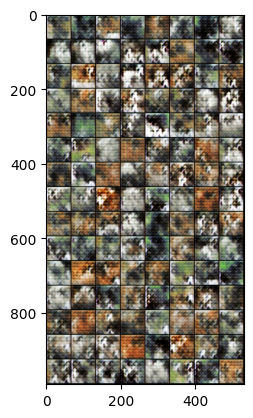

Epoch: 6 / 50
Discriminator Loss: 1.510
Generator Loss: 1.179
Epoch: 7 / 50
Discriminator Loss: 1.480
Generator Loss: 1.221
Epoch: 8 / 50
Discriminator Loss: 1.443
Generator Loss: 1.228
Epoch: 9 / 50
Discriminator Loss: 1.410
Generator Loss: 1.211
Epoch: 10 / 50
Discriminator Loss: 1.383
Generator Loss: 1.271


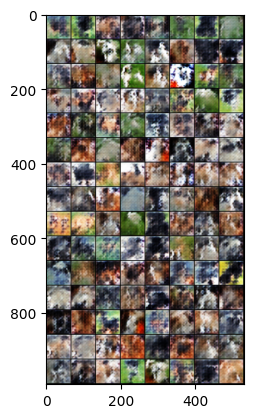

Epoch: 11 / 50
Discriminator Loss: 1.309
Generator Loss: 1.357
Epoch: 12 / 50
Discriminator Loss: 1.265
Generator Loss: 1.392
Epoch: 13 / 50
Discriminator Loss: 1.305
Generator Loss: 1.305
Epoch: 14 / 50
Discriminator Loss: 1.285
Generator Loss: 1.289
Epoch: 15 / 50
Discriminator Loss: 1.304
Generator Loss: 1.272


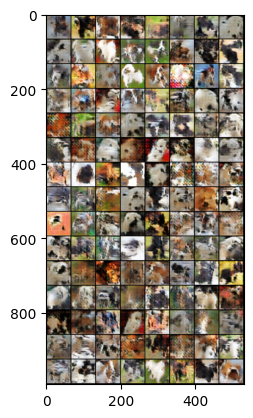

Epoch: 16 / 50
Discriminator Loss: 1.259
Generator Loss: 1.274
Epoch: 17 / 50
Discriminator Loss: 1.182
Generator Loss: 1.365
Epoch: 18 / 50
Discriminator Loss: 1.146
Generator Loss: 1.404
Epoch: 19 / 50
Discriminator Loss: 1.101
Generator Loss: 1.510
Epoch: 20 / 50
Discriminator Loss: 1.045
Generator Loss: 1.545


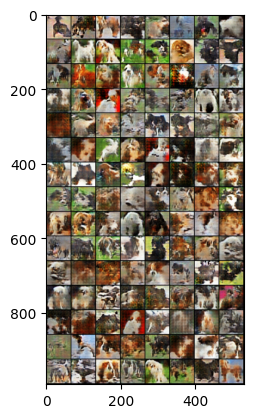

Epoch: 21 / 50
Discriminator Loss: 1.019
Generator Loss: 1.631
Epoch: 22 / 50
Discriminator Loss: 1.015
Generator Loss: 1.612
Epoch: 23 / 50
Discriminator Loss: 0.936
Generator Loss: 1.669
Epoch: 24 / 50
Discriminator Loss: 0.906
Generator Loss: 1.787
Epoch: 25 / 50
Discriminator Loss: 0.874
Generator Loss: 1.793


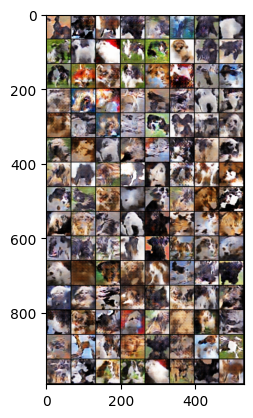

Epoch: 26 / 50
Discriminator Loss: 0.856
Generator Loss: 1.808
Epoch: 27 / 50
Discriminator Loss: 0.855
Generator Loss: 1.825
Epoch: 28 / 50
Discriminator Loss: 0.810
Generator Loss: 1.867
Epoch: 29 / 50
Discriminator Loss: 0.801
Generator Loss: 1.871
Epoch: 30 / 50
Discriminator Loss: 0.791
Generator Loss: 1.893


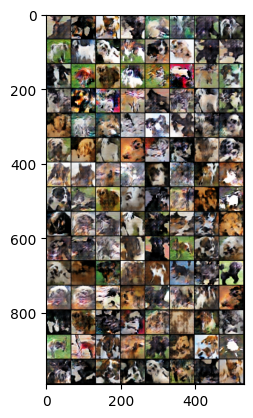

Epoch: 31 / 50
Discriminator Loss: 0.808
Generator Loss: 1.919
Epoch: 32 / 50
Discriminator Loss: 0.782
Generator Loss: 1.921
Epoch: 33 / 50
Discriminator Loss: 0.777
Generator Loss: 1.909
Epoch: 34 / 50
Discriminator Loss: 0.744
Generator Loss: 1.902
Epoch: 35 / 50
Discriminator Loss: 0.732
Generator Loss: 1.958


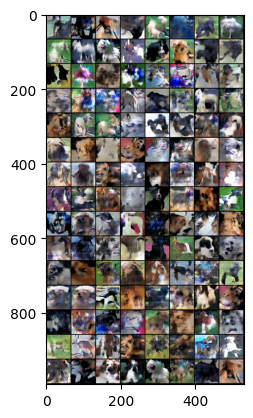

Epoch: 36 / 50
Discriminator Loss: 0.723
Generator Loss: 1.944
Epoch: 37 / 50
Discriminator Loss: 0.743
Generator Loss: 2.000
Epoch: 38 / 50
Discriminator Loss: 0.765
Generator Loss: 1.969
Epoch: 39 / 50
Discriminator Loss: 0.741
Generator Loss: 2.034
Epoch: 40 / 50
Discriminator Loss: 0.717
Generator Loss: 2.003


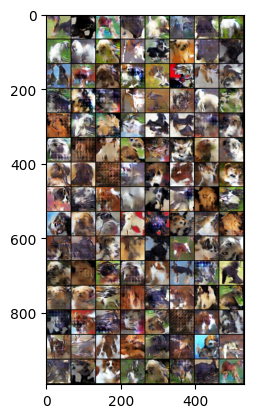

Epoch: 41 / 50
Discriminator Loss: 0.728
Generator Loss: 1.996
Epoch: 42 / 50
Discriminator Loss: 0.716
Generator Loss: 2.047
Epoch: 43 / 50
Discriminator Loss: 0.745
Generator Loss: 1.966
Epoch: 44 / 50
Discriminator Loss: 0.717
Generator Loss: 1.938
Epoch: 45 / 50
Discriminator Loss: 0.717
Generator Loss: 2.013


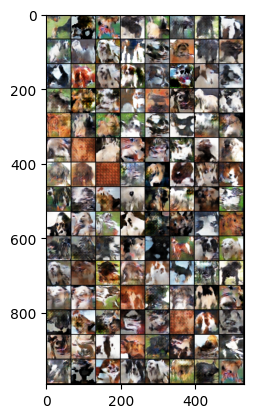

Epoch: 46 / 50
Discriminator Loss: 0.719
Generator Loss: 1.969
Epoch: 47 / 50
Discriminator Loss: 0.744
Generator Loss: 1.967
Epoch: 48 / 50
Discriminator Loss: 0.719
Generator Loss: 1.933
Epoch: 49 / 50
Discriminator Loss: 0.706
Generator Loss: 1.984
Epoch: 50 / 50
Discriminator Loss: 0.698
Generator Loss: 2.023


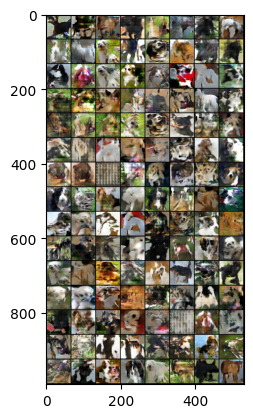

True

In [68]:
pbar = tqdm()

device = train_config.device

for epoch in range(train_config.epochs):
    print(f"Epoch: {epoch + 1} / {train_config.epochs}")
    pbar.reset(total=len(train_loader))

    # Set up losses
    generator_losses, discriminator_losses = [], []

    for i, data in enumerate(train_loader):
        # Move images and labels to device
        real_images = data["images"].to(device)
        real_labels = data["labels"].to(device)
        # Get batch size
        current_batch_size = real_images.size()[0]
        ## Get real and fake data
        real_valid = torch.ones(current_batch_size, 1).to(device)
        fake_valid = torch.zeros(current_batch_size, 1).to(device)

        ''' Train the Generator '''
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, train_config.noise_size)).to(device)
        fake_images = generator(input_noise, real_labels)
        disc_fake_valid = discriminator(fake_images, real_labels)

        generator_loss = adversarial_loss(disc_fake_valid, real_valid)
        generator_loss.backward()
        generator.optimizer.step()
        generator_losses.append(generator_loss)

        ''' Train the Discriminator '''
        discriminator.zero_grad()

        ## Calculate real loss
        disc_real_valid = discriminator(real_images, real_labels)
        disc_real_loss = adversarial_loss(disc_real_valid, real_valid)

        ### Calculate wrong loss
        wrong_labels = torch.randint(0, n_classes, (current_batch_size, )).to(device)
        disc_wrong_valid = discriminator(real_images, wrong_labels)
        disc_wrong_loss = adversarial_loss(disc_wrong_valid, fake_valid)

        ## Calculate fake loss
        disc_fake_valid = discriminator(fake_images.detach(), real_labels)
        disc_fake_loss = adversarial_loss(disc_fake_valid, fake_valid)

        ####### Calculating total loss
        discriminator_loss = disc_real_loss + disc_wrong_loss + disc_fake_loss
        if discriminator_loss > 0.5:
            discriminator_loss.backward()
            discriminator.optimizer.step()
        else:
            discriminator_loss = discriminator_loss.detach()
        discriminator_losses.append(discriminator_loss)

        pbar.update()

    print(f"Discriminator Loss: {torch.mean(torch.FloatTensor(discriminator_losses)):.3f}")
    print(f"Generator Loss: {torch.mean(torch.FloatTensor(generator_losses)):.3f}")

    if (epoch + 1) % train_config.save_epoch == 0:
        plot_output(epoch + 1)


pbar.refresh()